In [1]:
import numpy as np
import matplotlib.pyplot as plt
import config as cf
import data_loader as dl
from scipy.stats import poisson, chi2, ncx2

import seaborn as sns
# Apply the default theme
#sns.set_theme(palette='dark')
#sns.set_style("whitegrid")

# ---- Thesis config 1 -----
#Set LaTeX rendering for fonts

# Define a professional, colorblind-friendly palette
sns.set_palette("colorblind") # "colorblind", "deep", "muted"
# sns.set_palette([
#     "#1f77b4",  # blue – neutral & reliable
#     "#d62728",  # red – classic for electron neutrinos
#     "#2ca02c",  # green – flavor mix / survival probability
#     "#9467bd",  # purple – sterile or x flavor
#     "#ff7f0e",  # orange – \bar{ν}_e or energy density
#     "#17becf"   # cyan – cosmic or detector background
# ])
sns.set_palette([
    "#1b9e77",  # green-teal
    "#d95f02",  # orange
    "#7570b3",  # violet-blue
    "#e7298a",  # magenta-pink
    "#66a61e",  # lime green
    "#e6ab02",  # yellow
    "#a6761d",  # brown
    "#666666"   # gray
])
PALETTE = sns.color_palette()

# Set seaborn style and context for clarity and professionalism
sns.set_style("whitegrid", {
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.color': '.9',
    'grid.linestyle': '--'
})

# Set context to ensure large, thesis-friendly text
sns.set_context("talk", rc={
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "lines.linewidth": 2.5,
    "lines.markersize": 8,

})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{lmodern}",
    #"font.serif": ["Times"],
    #"text.latex.preamble": r"\usepackage{amsmath}", 
})

[11:39:49] INFO     Configuration file loaded from:                                                    ]8;id=653991;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=71186;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#28\28]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway             
                    /trigger/scripts/../configs/default_config_vd.yaml                                             

           INFO     Default config file is:                                                            ]8;id=727495;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=132242;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#32\32]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway             
                    /trigger/scripts/../configs/default_config_vd.yaml                                             

           INFO     Loaded detector coordinates from file:                                            ]8;id=147213;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py\config.py]8;;\:]8;id=653653;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/config.py#149\149]8;;\
                    /Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/mywa              
                    y/trigger/scripts/../aux_data/detector_coordinates/pdpos_vd1x8x14v5.dat                        

           INFO     SN time profile loaded from ../aux_data/TimeProfile.root                     ]8;id=319776;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/data_loader.py\data_loader.py]8;;\:]8;id=974586;file:///Users/pbarham/Library/CloudStorage/OneDrive-Personal/workspace/cern/trigger/myway/trigger/scripts/data_loader.py#773\773]8;;\

Total sum: 0.9984137845968193
Total sum: 0.9457272609069004


/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_29064/4160732924.py:64: RuntimeWarning: invalid value encountered in divide
  to_max_pearson = mu**2/k * s**2 / t
/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_29064/4160732924.py:68: RuntimeWarning: invalid value encountered in divide
  to_max_cash = -mu*s + (mu*s + k*t) * np.log(1 + mu*s/(k*t))


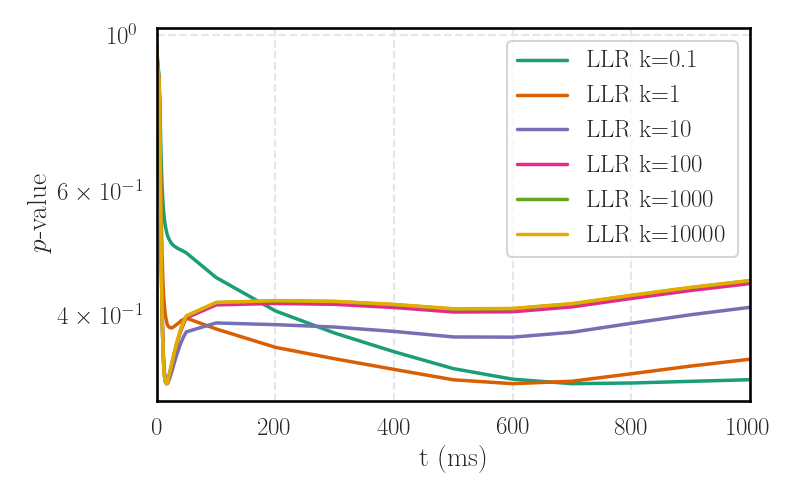

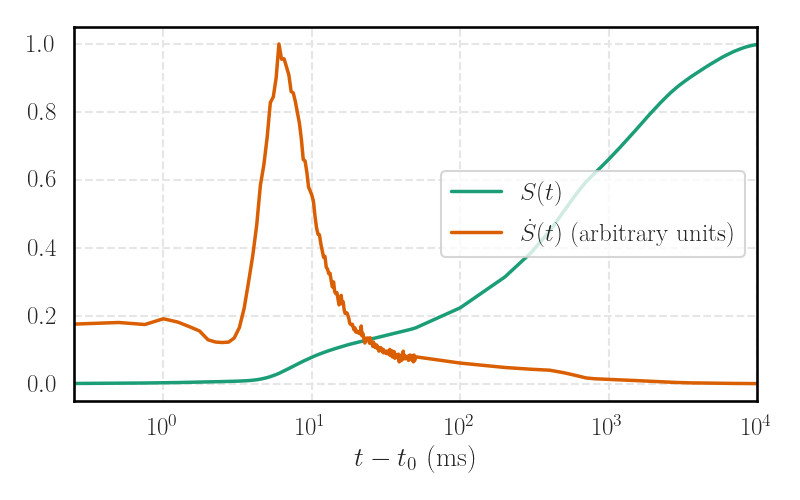

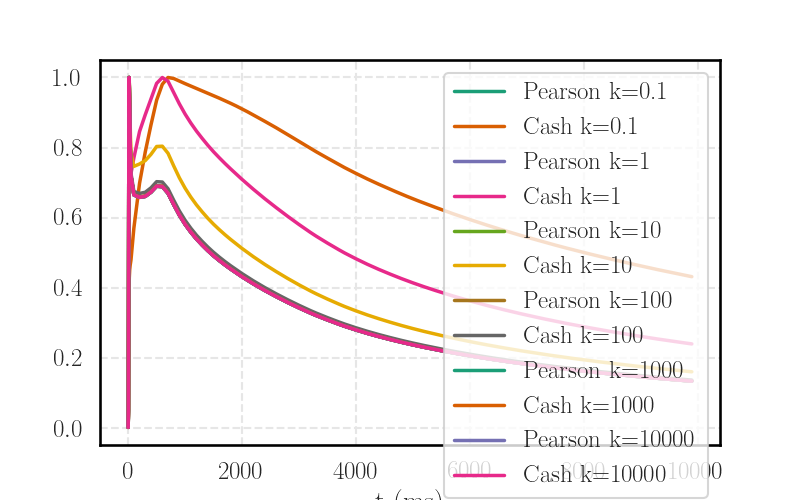

In [20]:
%matplotlib widget
# Load the config 
config_path = '../configs/default_config_vd.yaml'
config = cf.Configurator.from_file(config_path)

# Load the time profile histogram
data_loader = dl.DataLoader(config)
time_profile_x, time_profile_y = data_loader.load_time_profile()
t, sdot = time_profile_x, time_profile_y

#print(t)

# Shift t to the center of the time interval
#t = t + 0.5 * (t[1] - t[0])

# Compute the numerical integral I(t) = \int_0^t I(t') dt'
diff = np.diff(t)
# Note that this integral should add up to 1, and it does. This means
# however that sdot is not given as an event density, and we must divide by the time interval
s = np.cumsum(sdot)
print(f'Total sum: {np.sum(sdot)}')
sdot = sdot / diff
# The first entry of the integral should be 0, correspoding to the leftmost edge of the "bin"
# We can shave off the last entry as it will be irrelevant
s = np.insert(s, 0, 0)
s = s[:-1]
t = t[:-1]

#print(len(s), len(sdot), len(t))

# Finally, we can scale by a total number of "events" (i.e., clusters in a bin per ms)
scale = 1
sdot = sdot * scale
s = s * scale
print(f"Total sum: {np.trapz(sdot, t)}")

# Plot the time profile
plt.figure(figsize=(8, 5))
plt.plot(t[1:], s[1:], label=r'$S(t)$')
plt.plot(t[1:], sdot[1:] / np.max(sdot[1:]), label=r'$\dot{S}(t)$ (arbitrary units)')
plt.xlim(t[1:][0], 10000)
plt.xscale('log')
plt.xlabel(r'$t-t_0$ (ms)')
plt.legend()
plt.tight_layout()
# Save the figure with tight bounding box and high dpi
plt.savefig("../local_saves/plot_outputs/time_profile_logx.pdf", bbox_inches='tight', dpi=600)

# # The equation to solve...
# lhs = 2 * sdot * t - s
# plt.figure()
# plt.plot(t, lhs)
# plt.axhline(0, color='black', linestyle='--')

mu = 1000
# # The quantity to maximize is
fig, ax = plt.subplots(figsize=(8, 5))
fig2, ax2 = plt.subplots(figsize=(8, 5))

# A large range of k values 
krange = [1e-1, 1, 10, 100, 1000, 10000]
krange = [1e-1, 1, 10, 100, 1000, 10000]
for k in krange:
    to_max_pearson = mu**2/k * s**2 / t
    to_max_pearson = to_max_pearson / np.nanmax(to_max_pearson)
    ax.plot(t, to_max_pearson, label=f'Pearson k={k}')

    to_max_cash = -mu*s + (mu*s + k*t) * np.log(1 + mu*s/(k*t))
    to_max_cash = to_max_cash / np.nanmax(to_max_cash)
    ax.plot(t, to_max_cash, label=f'Cash k={k}')

    # pval_pearson = chi2.sf(to_max_pearson, 1)
    # ax2.plot(t, pval_pearson, label=f'Pearson k={k}', linestyle='--')

    pval_cash = chi2.sf(to_max_cash, 1)
    ax2.plot(t, pval_cash, label=f'LLR k={k}')

ax.legend()
ax.set_xlabel('t (ms)')

ax2.legend()
ax2.set_xlabel('t (ms)')
ax2.set_ylabel(r'$p$-value')
ax2.set_yscale('log')
ax2.set_xlim(0, 1000)

fig2.tight_layout()

plt.show()

/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_29064/2009623584.py:17: RuntimeWarning: invalid value encountered in divide
  delta = (lambda_1 - lambda_0)**2 / lambda_0


0.9999837375048628
0.3209506657217076
0.080850026558975
0.01987419695779724
0.005668983614477541


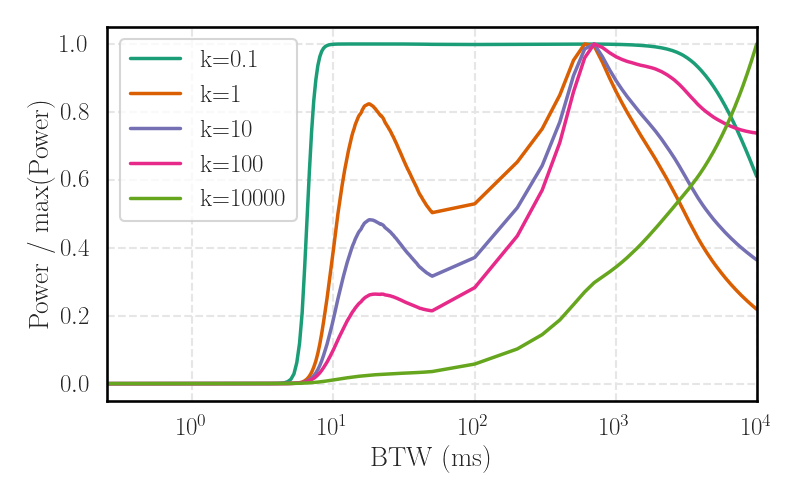

In [22]:
krange = [0.1, 1, 10, 100, 1000, 10000]
krange = [0.1, 0.5, 1, 2, 10]
k_dict = {0.1: '0.1', 0.5: '1', 1: '10', 2: '100', 10: '10000'}
mu = 100
chi2_frozen = chi2(df=1)

# Define the critical p-value and critical LLR threshold
ftr = 1 / (30 * 24 * 60 * 60) # 1 event per 30 days
p_critical = ftr * t

fig, ax = plt.subplots(figsize=(8, 5))

for k in krange:
    lambda_0 = k * t
    lambda_1 = k * t + mu * s

    delta = (lambda_1 - lambda_0)**2 / lambda_0

    llr_threhsold = chi2_frozen.ppf(1 - p_critical)

    # Power (z)
    # Define the non-central chi-squared distribtion
    non_central_frozen = ncx2(df=1, nc=delta)
    power = 1 - non_central_frozen.cdf(llr_threhsold)

    max_power = np.nanmax(power)
    print(max_power)
    #max_power = 1
    ax.plot(t[1:], power[1:] / max_power, label=f'k={k_dict[k]}')

ax.set_xlim(t[1:][0], 10000)
ax.set_xlabel('BTW (ms)')
ax.set_ylabel('Power / max(Power)')

ax.legend()
ax.set_xscale('log')
plt.tight_layout()


# Save the figure with tight bounding box and high dpi
fig.savefig("../local_saves/plot_outputs/power_vs_btw_logx.pdf", bbox_inches='tight', dpi=600)



/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_60610/439321851.py:4: RuntimeWarning: invalid value encountered in divide
  pval = chi2.sf(s**2/(k*t), dof)  # = 1 - chi2.cdf(s**2/t, dof)


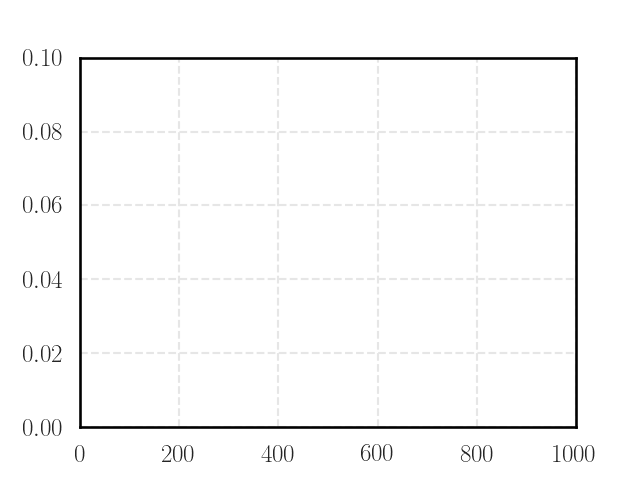

In [ ]:
# Actually, we want to minimise the p-value! 
dof = 10
k = 0.01
pval = chi2.sf(s**2/(k*t), dof)  # = 1 - chi2.cdf(s**2/t, dof)

# And even better, divide over t!
pval_over_t = pval/t

plt.figure()
plt.plot(t, pval_over_t)
plt.xlim(0, 1000)
plt.ylim(0, 0.1)
plt.show()

## Beyond this is nonsense

Llr peaks at 0.0


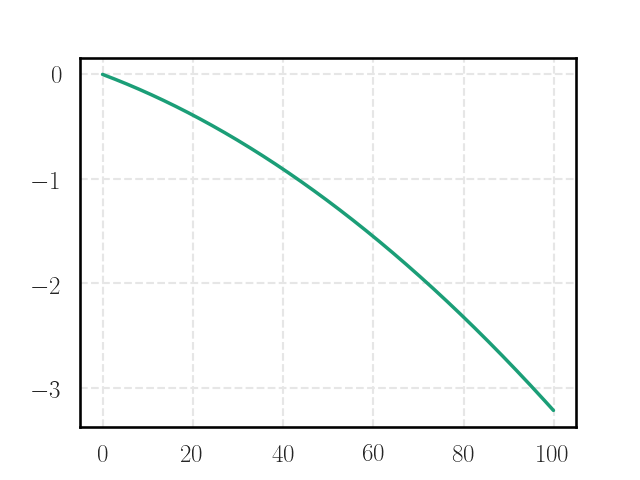

In [5]:
# Other bullshit

n = 6145
nprime = np.arange(0, 100, 0.1)
N = n + nprime

k = n - 50

# Log likelihood ratio
llr = -2 * (-k * np.log(1 + nprime/n) + nprime)
print(f"Llr peaks at {nprime[np.argmax(llr)]}")

plt.figure()
plt.plot(nprime, llr)
plt.show()

ftr_0 = 3.858024691358025e-07


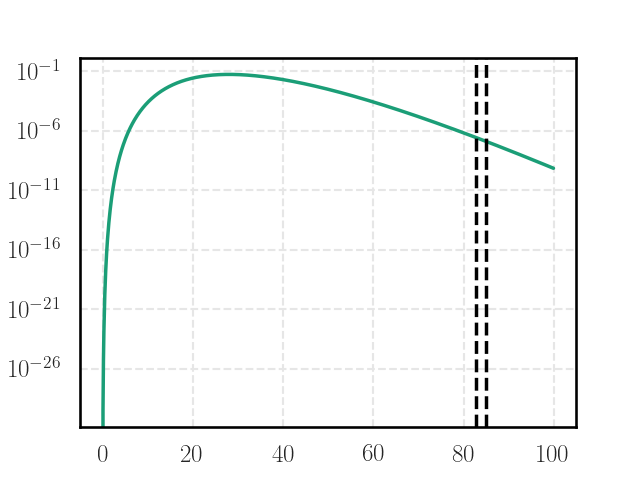

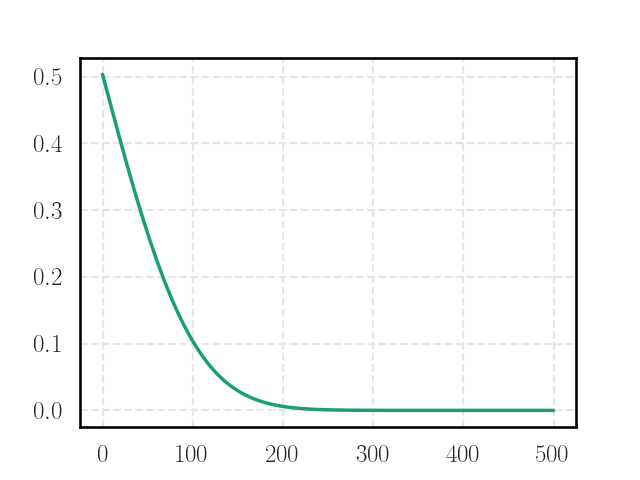

In [6]:
# More bullshit

df = 30
chi2_stat = np.arange(0, 100, 0.1)

ftr_0 = 1 / 30 / 24 / 60 / 60
print(f'ftr_0 = {ftr_0}')
ftr_1 = 2 * ftr_0 

chi2_pdf = chi2.pdf(chi2_stat, df)
pval = chi2.sf(chi2_stat, df) # Survival function, i.e., 1 - CDF, but with better numerical properties

plt.figure()
plt.plot(chi2_stat, chi2_pdf)
plt.axvline(chi2.isf(ftr_0, df), color='black', linestyle='--')
plt.axvline(chi2.isf(ftr_1, df), color='black', linestyle='--')
plt.yscale('log')

# plt.figure()
# plt.plot(chi2_stat, pval)
# plt.axhline(ftr_0, color='black', linestyle='--')
# plt.axhline(ftr_1, color='black', linestyle='--')
# plt.yscale('log')

# How many SN bursts do we miss if we cut at k < n...
n = 6145
nprime = np.arange(0, 500, 0.1)
# Prob(k < n; lambda=n+nprime) = CDF(n; lambda=n+nprime)
pmiss = poisson.cdf(n, n + nprime)

plt.figure()
plt.plot(nprime, pmiss)